# Set up

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install pycocotools>=2.0.2

In [ ]:
!pip install timm>=0.3.2

In [ ]:
!pip install omegaconf>=2.0

In [ ]:
!pip install ensemble-boxes

In [ ]:
! pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 8.1MB/s 
     |████████████████████████████████| 952kB 13.2MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65163 sha256=d7fb0183a3d92ab0c590b4b3ca75aa1829a972217d87d2124216479be028e4e4
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
!pip install effdet

     |████████████████████████████████| 112kB 6.8MB/s 


In [ ]:
import sys
import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from glob import glob
import warnings
from collections import Counter

from ensemble_boxes import weighted_boxes_fusion
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.utils.data.dataloader import default_collate

from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
from effdet import create_model, unwrap_bench, create_loader, create_dataset, create_evaluator, create_model_from_config
from effdet.data import resolve_input_config, SkipSubset
from effdet.anchors import Anchors, AnchorLabeler
from timm.models import resume_checkpoint, load_checkpoint
from timm.utils import *
from timm.optim import create_optimizer
from timm.scheduler import create_scheduler

In [ ]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)

In [ ]:
!mkdir working

In [ ]:
!cp '/content/drive/MyDrive/effDet/test.rar' '/content/working/test.rar'

In [ ]:
!unrar x '/content/working/test.rar' '/content/working/test/'


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/working/test.rar

Creating    /content/working/test                                     OK
Extracting  /content/working/test/test.csv                                 0%  OK 
Creating    /content/working/test/test                                OK
Extracting  /content/working/test/test/002a34c58c5b758217ed1f584ccbcfe9.jpg       0%  OK 
Extracting  /content/working/test/test/004f33259ee4aef671c2b95d54e4be68.jpg       0%  OK 
Extracting  /content/working/test/test/008bdde2af2462e86fd373a445d0f4cd.jpg       0%  OK 
Extracting  /content/working/test/test/009bc039326338823ca3aa84381f17f1.jpg       0%  OK 
Extracting  /content/working/test/test/00a2145de1886cb9eb88869c85d74080.jpg       0%  OK 
Extracting  /content/working/test/test/00b7e6bfa4dc1fe9ddd0ce74743e38c2.jpg       0%  OK 
Extracting  /content/working/test/test/011295e0bcdc76365

## Define Training Configuration

In [ ]:
class TrainGlobalConfig:
    def __init__(self):
        self.num_classes = 14
        self.num_workers = 0
        self.batch_size = 4
        self.n_epochs = 10
        self.lr = 0.0002
        self.model_name = 'tf_efficientdet_d7'
        self.folder = 'training_job'
        self.verbose = True
        self.verbose_step = 1
        self.step_scheduler = True
        self.validation_scheduler = False
        self.n_img_count = 3000
        self.OptimizerClass = torch.optim.AdamW
        self.SchedulerClass = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts
        self.scheduler_params = dict(
                            T_0=50,
                            T_mult=1,
                            eta_min=0.0001,
                            last_epoch=-1,
                            verbose=False
                            )
        self.kfold = 1
    
    def reset(self):
        self.OptimizerClass = torch.optim.AdamW
        self.SchedulerClass = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts

train_config = TrainGlobalConfig()

# Inference

## Test set retriever

In [ ]:
TEST_ROOT_PATH = '/content/working/test/test'

class TestsetRetriever(Dataset):

    def __init__(self, image_ids, dataframe, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.df = dataframe
        self.transforms = transforms
        
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image_w = self.df[(self.df['image_id'] == image_id)]['width']
        image_h = self.df[(self.df['image_id'] == image_id)]['height']
        
        image = self.load_image(index)

        return image, image_id, image_w, image_h

    def __len__(self):
        return self.image_ids.shape[0]
    
    def load_image(self, index):
        image_id = self.image_ids[index]

        image = cv2.imread(f'{TEST_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR).copy()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        if self.transforms:
          resized = self.transforms(**{'image': image})

        return resized['image']

In [ ]:
def get_test_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [ ]:
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    
    return tuple(zip(*batch))

test_df = pd.read_csv('/content/working/test/test.csv')
test_ids = test_df.image_id
    
test_dataset = TestsetRetriever(
                        image_ids=test_ids,
                        dataframe=test_df,
                        transforms=get_test_transforms()
                        )

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=train_config.batch_size,
    num_workers=train_config.num_workers,
    shuffle=False,
    sampler=SequentialSampler(test_dataset),
    pin_memory=False,
    collate_fn=collate_fn,
)

## Load model

In [ ]:
!mkdir training_job

In [ ]:
!cp '/content/drive/MyDrive/effDet/best-checkpoint-013epoch (1).bin' '/content/training_job/best-checkpoint-013epoch (1).bin'

In [ ]:
checkpoint_path = '/content/training_job/best-checkpoint-013epoch (1).bin'

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

base_config = get_efficientdet_config(train_config.model_name)
# base_config.image_size = (512, 512)

print(f'Loading model from checkpoint: {checkpoint_path}')        
model = create_model_from_config(base_config, bench_task='predict', bench_labeler=True,
                          num_classes=train_config.num_classes,
                          pretrained=False)
checkpoint = torch.load(checkpoint_path)
model.model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

Loading model from checkpoint: /content/training_job/best-checkpoint-013epoch (1).bin


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b6_aa-80ba17e4.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b6_aa-80ba17e4.pth


DetBenchPredict(
  (model): EfficientDet(
    (backbone): EfficientNetFeatures(
      (conv_stem): Conv2dSame(3, 56, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn1): BatchNorm2d(56, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (act1): SiLU(inplace=True)
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=56, bias=False)
            (bn1): BatchNorm2d(56, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (act1): SiLU(inplace=True)
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(56, 14, kernel_size=(1, 1), stride=(1, 1))
              (act1): SiLU(inplace=True)
              (conv_expand): Conv2d(14, 56, kernel_size=(1, 1), stride=(1, 1))
            )
            (conv_pw): Conv2d(56, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(32, ep

In [ ]:
def format_prediction_string(labels, boxes, scores):
    pred_strings = []
    for j in zip(labels, scores, boxes):
        pred_strings.append("{0} {1:.4f} {2} {3} {4} {5}".format(
            j[0], j[1], j[2][0], j[2][1], j[2][2], j[2][3]))

    return " ".join(pred_strings)

def resize_bbox(box, w_scale, h_scale):
  resized_box = box.copy()
  resized_box[0] = box[0]*w_scale
  resized_box[2] = box[2]*w_scale
  resized_box[1] = box[1]*h_scale
  resized_box[3] = box[3]*h_scale
  return resized_box

## Infer

In [ ]:
detection_threshold = 0.5
results = []
all_labels = []

with torch.no_grad():

  for images, image_ids, image_ws, image_hs in tqdm(test_loader):
    # images = images[0].unsqueeze(0).to(device)
    images = torch.stack(images)
    images = images.to(device).float()
    # images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):
      image_id = image_ids[i]
      image_w = image_ws[i]
      image_h = image_hs[i]
      w_scale = image_w / 512
      h_scale = image_h / 512

      result = {
      'image_id': image_id,
      'PredictionString': '14 1.0 0 0 1 1'
      }

      boxes = np.array([out[:4].cpu().numpy() for out in outputs[i]])
      labels = np.array([out[-1].cpu().numpy() for out in outputs[i]])
      scores = np.array([out[4].cpu().numpy() for out in outputs[i]])

      if len(boxes) > 0:
        selected = scores >= detection_threshold

        boxes = boxes[selected]
        scores = scores[selected]
        labels = labels[selected].astype(np.int32)

        if len(boxes) > 0:
          resized_box = [resize_bbox(box, w_scale, h_scale) for box in boxes]           
          resized_bboxes = np.vstack((list(bx) for bx in resized_box))
          # resized_bboxes = np.vstack((list(bx) for bx in boxes))
          result = {
          'image_id': image_id,
          'PredictionString': format_prediction_string(labels, resized_bboxes, scores)
          }

      results.append(result)
      all_labels.extend(labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


In [ ]:
test_result = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_result.sample(10)

,image_id,PredictionString
1801,9dd83beafe70432164f9945fef7da826,14 1.0 0 0 1 1
1190,3d281a2a2c78f8e0713166ed125a183a,14 1.0 0 0 1 1
1817,33710a9edd291057f356433bcb50a632,14 1.0 0 0 1 1
251,f1bf0692779f838803453642c8f17c66,14 1.0 0 0 1 1
2505,a471a7ca10ccf8c873b6cc82fcedd4aa,14 1.0 0 0 1 1
1117,67626c635c3b17db4acd9052a06f8be5,14 1.0 0 0 1 1
1411,4f5fe9950e605a42d75ea7bfb8230866,14 1.0 0 0 1 1
2113,5e0e46b7af5381ca4af6a51e7992a69f,14 1.0 0 0 1 1
408,10d3204872c83731aeaee57e020b768a,3 0.5889 5671.255859375 978.4619140625 6206.45...
2579,49c8db913e71138d6d0bbea0ab047490,14 1.0 0 0 1 1


In [ ]:
test_result.to_csv('submission.csv', index=False)

In [ ]:
test_result['PredictionString'] = ['14 1.0 0 0 1 1']*3000

In [ ]:
count = pd.DataFrame(pd.DataFrame(all_labels)[0].value_counts()).reset_index()
count.columns = ['class','count']
count

,class,count
0,3,1191
1,13,43
2,8,21
3,10,18
4,11,9
5,7,3


In [ ]:
count = count.append({'class':14, 'count':1741}, ignore_index=True)

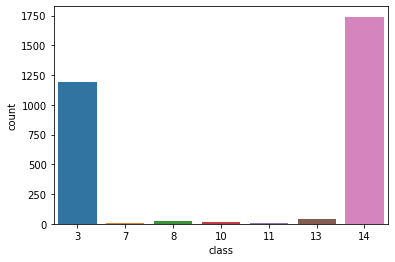

In [ ]:
import seaborn as sns
sns.barplot(x='class', y='count', data=count)